# New Approach using fast ai

In [ ]:
import fastai

In [ ]:
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
import typing

# resnet 34 lerner and Pets dataset

In [ ]:
resnet34 = models.resnet34

In [ ]:
path = untar_data(URLs.PETS)

In [ ]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [ ]:
# Setting the path for high res, low res and medium res images
path_hr = path/'images'
path_lr = path/'small-128'
path_mr = path/'small-256'

# Abstraction provided by fastai on top of pytorch really helps

In [ ]:
high_res_images = ImageList.from_folder(path_hr)

In [ ]:

def resize_one(fn:Path, i, path_save, size) -> None:
    dest = path_save / fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok = True)
    
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min = True)
    
    img = img.resize(targ_sz, resample = PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=40)

In [ ]:
path_save = path_lr
#size = 256
size = 128
parallel(partial(resize_one,path_save=path_save, size=size), high_res_images.items)

In [ ]:
path_save = path_mr
size = 256
#size = 128
parallel(partial(resize_one,path_save=path_save, size=size), high_res_images.items)

# setting the batch size to 32 and size of the lr image to 128

In [ ]:
bs ,size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed = 42)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:217: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


In [ ]:
def get_data(bs:int, size:int):
    data = src.label_from_func(lambda x:path_hr/x.name)\
    .transform(get_transforms(max_zoom=2.), size=size, tfm_y = True)\
    .databunch(bs = bs).normalize(imagenet_stats, do_y = True)
    
    data.c = 3
    return data

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = get_data(bs, size)


In [ ]:
data

ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/small-128;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/small-128;

Test: None

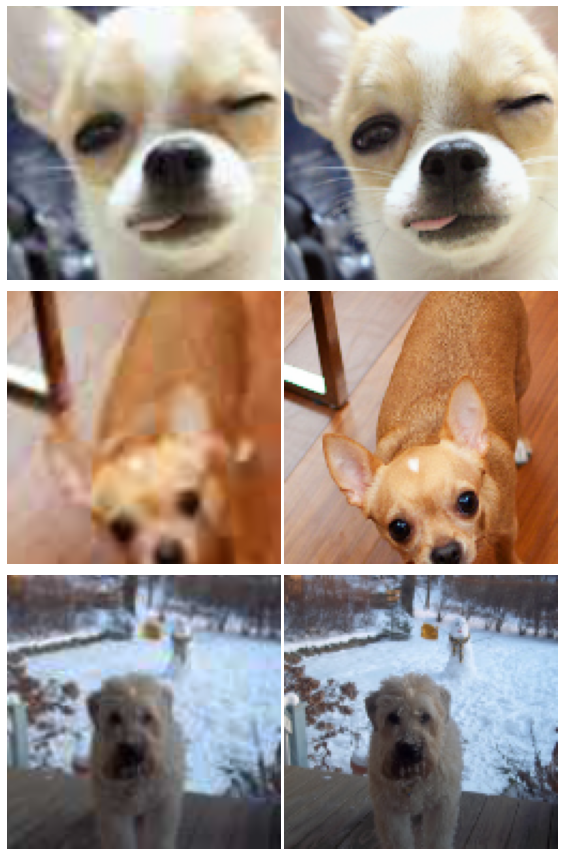

In [ ]:
data.show_batch(rows=3, fig_size=(9,9))

In [ ]:

t = data.valid_ds[0][1].data

t1 = torch.stack([t,t])

In [ ]:
t.shape

torch.Size([3, 128, 128])

In [ ]:
t1.shape

torch.Size([2, 3, 128, 128])

In [ ]:

# Define the gram matrix equation : x*x'
def gram_mat(x:torch.Tensor) -> torch.Tensor: 
    n, c, h, w =  x.size()
    
    # resize
    x = x.view(n,c,-1)
    
    return x@x.transpose(1,2)/(c*h*w)

In [ ]:
gram_mat(t1)

tensor([[[0.0569, 0.0555, 0.0576],
         [0.0555, 0.0544, 0.0565],
         [0.0576, 0.0565, 0.0587]],

        [[0.0569, 0.0555, 0.0576],
         [0.0555, 0.0544, 0.0565],
         [0.0576, 0.0565, 0.0587]]])

In [ ]:
base_loss = F.l1_loss

In [ ]:

body = create_body(models.resnet34, pretrained=True).cuda().eval()
requires_grad(body, False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
m_sizes = model_sizes(body, (224,224))
m_sizes

[torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 112, 112]),
 torch.Size([1, 64, 56, 56]),
 torch.Size([1, 64, 56, 56]),
 torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7])]

In [ ]:
list_idx = [i for i,x in enumerate(m_sizes) if i<len(m_sizes)-1 and not(x == m_sizes[i+1])]

In [ ]:
list_idx.append(len(m_sizes)-1)

In [ ]:
list_idx

[2, 4, 5, 6, 7]

# defining the feature loss class

In [ ]:

class FeatureLoss(nn.Module):
    def __init__(self, feat_body, layer_idx, layer_weight):
        super().__init__()
        self.feat_body = feat_body
        self.loss_features = [self.feat_body[i] for i in layer_idx]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.weight = layer_weight
        
        self.metric_names = ['pixel_L1'] +\
        [f'feature_L1_{i}' for i in layer_idx] + [f'feature_L1_Gram_{i}' for i in layer_idx]
    
    def get_features(self, x, clone=False):
        self.feat_body(x)
        return [o.clone() if clone else o for o in self.hooks.stored]
    
    def forward(self, x_input, target):
        out_feat = self.get_features(target, clone=True)
        in_feat = self.get_features(x_input)
        
        self.f_losses = [base_loss(x_input, target)]
        
        self.f_losses += [base_loss(f_in, f_out)*w \
                          for f_in,f_out,w in zip(in_feat, out_feat,self.weight)]
        
        self.f_losses += [base_loss(gram_mat(f_in), gram_mat(f_out))*(w*1e3) \
                          for f_in,f_out,w in zip(in_feat, out_feat,self.weight)] # more weight for this
        
        self.metrics = dict(zip(self.metric_names, self.f_losses))
        
        return sum(self.f_losses)

In [ ]:
feat_loss = FeatureLoss(body, list_idx, [15,2,5,5,0.3])

In [ ]:
t1_c = t1.cuda()

In [ ]:
feat_loss(t1_c, t1_c)


tensor(0., device='cuda:0')

In [ ]:
arch

<function torchvision.models.resnet.resnet34>

# creating unet learner with weigh decay of 1e-3 and passing the feature loss

In [ ]:

wd = 1e-3
learn = unet_learner(data, arch, wd = wd, loss_func= feat_loss,\
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight)

In [ ]:
gc.collect()

13292

# using lr find to find the perfect learning rate this is really fascinating

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


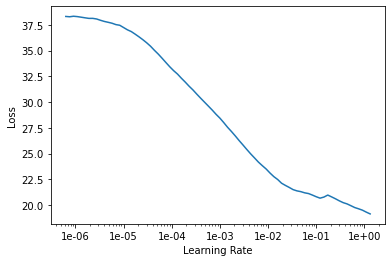

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-3

# fitting the model for 20 epochs

In [ ]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(20, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize= 5)

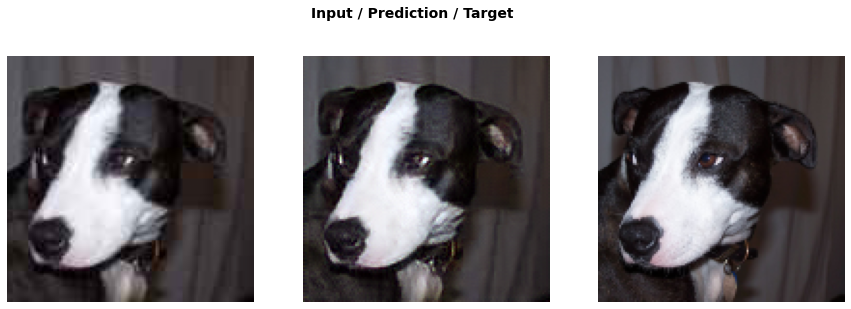

In [ ]:
do_fit('128_freeze')

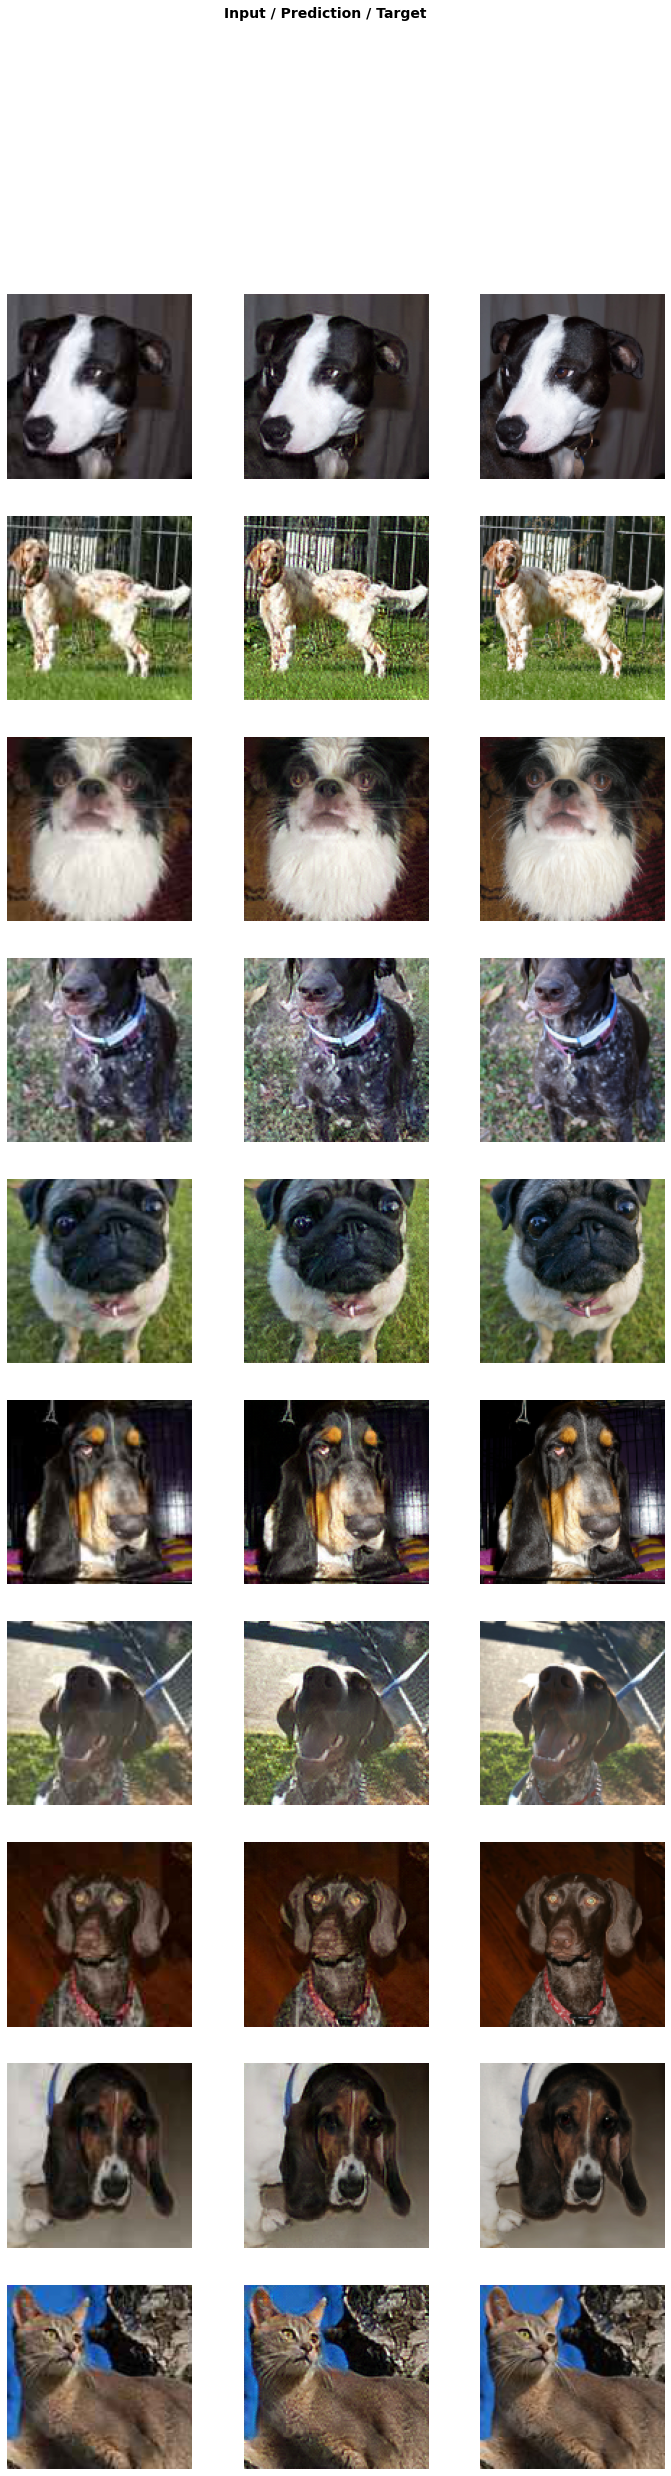

In [ ]:
learn.show_results(rows=10)

In [ ]:
learn.unfreeze()

# unfreezing and then training again

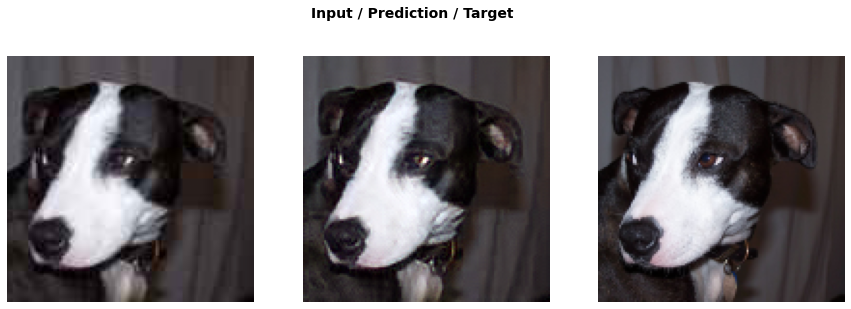

In [ ]:
do_fit('128_unfreeze', slice(1e-5,1e-3))

#checking the images generated

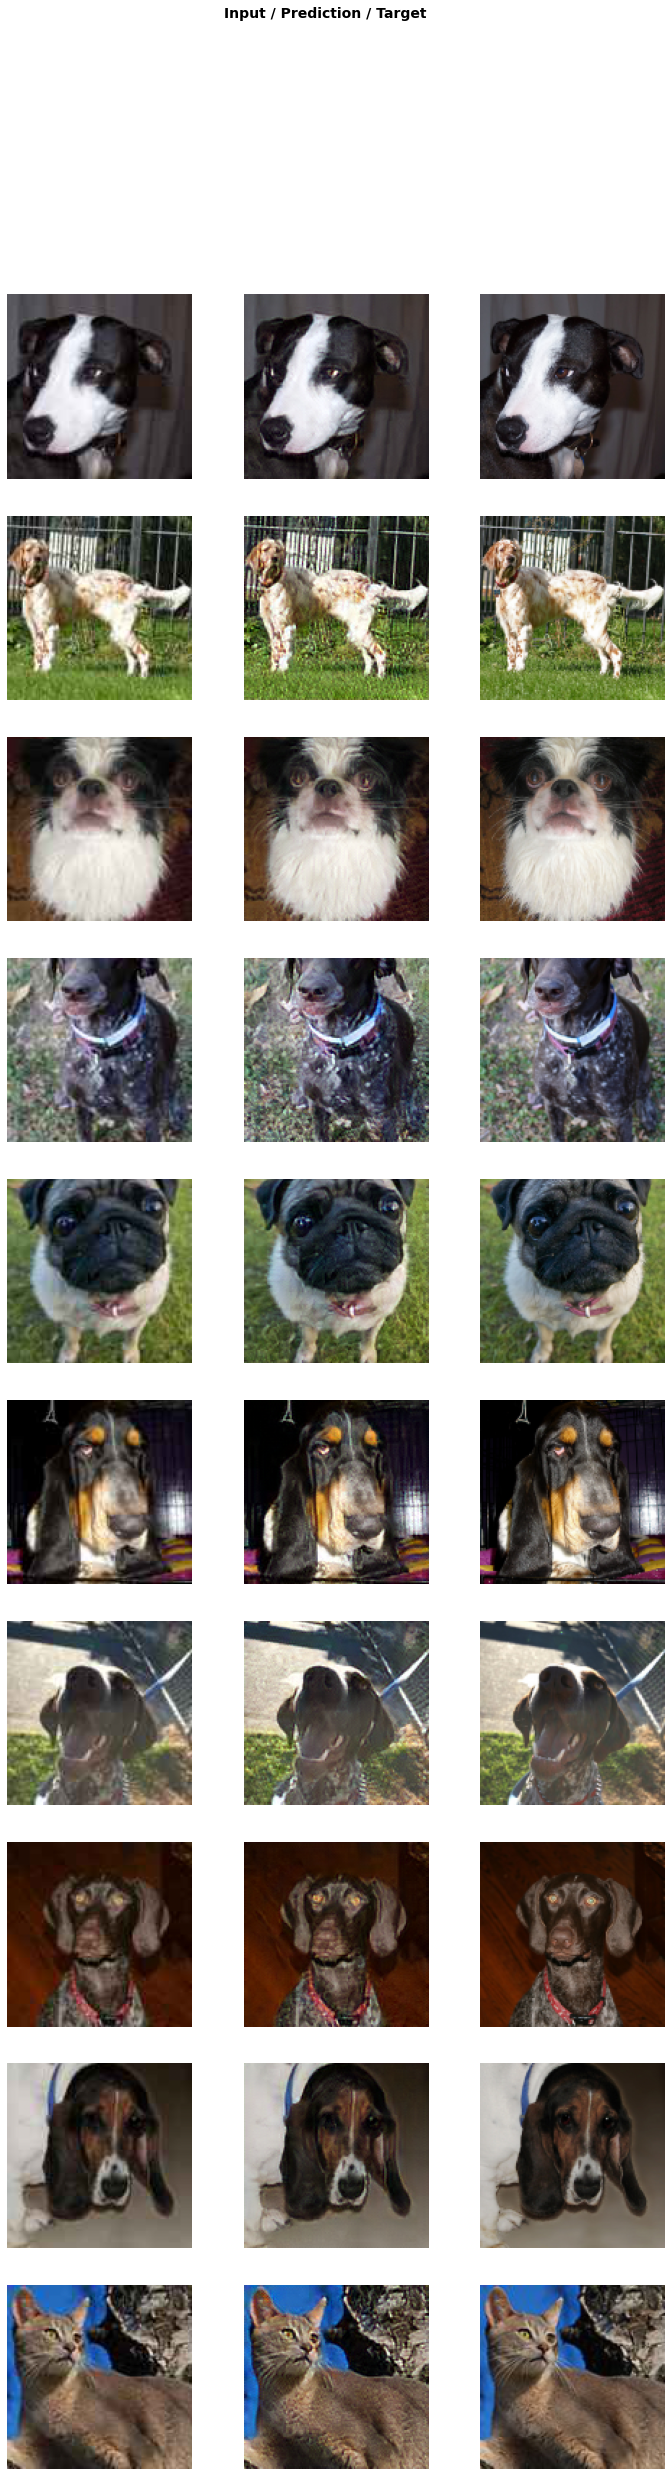

In [ ]:
learn.show_results(rows=10)

In [ ]:
learn = None
gc.collect()

64409

In [ ]:
free = gpu_mem_get_free_no_cache()
free

6764

In [ ]:
size=( 820, 1024)

# now uisng the model to super resolve a 256 size image and then checking the results

In [ ]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [ ]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [ ]:
learn.load('128_unfreeze');

In [ ]:
learn.data = data_mr

In [ ]:
fn = path/'small-256/Siamese_178.jpg'

In [ ]:
img = open_image(fn); img.shape

torch.Size([3, 256, 320])

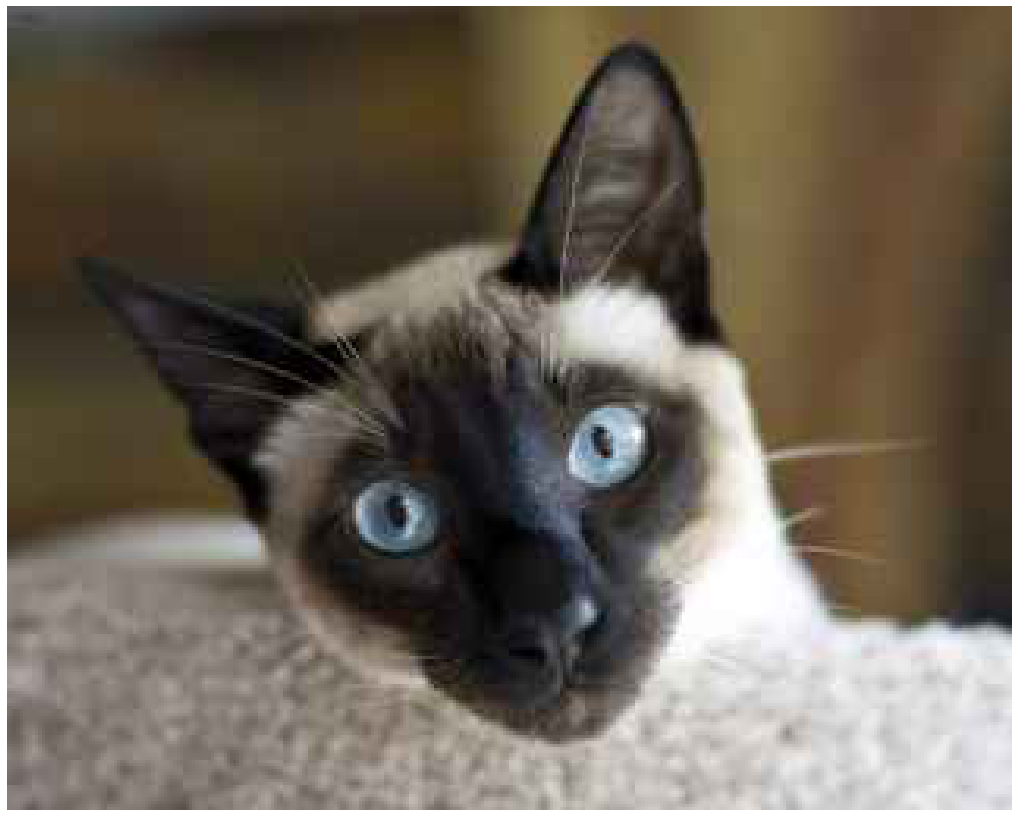

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [ ]:
p, img_hr, b = learn.predict(img)

In [ ]:
type(img_hr)

torch.Tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


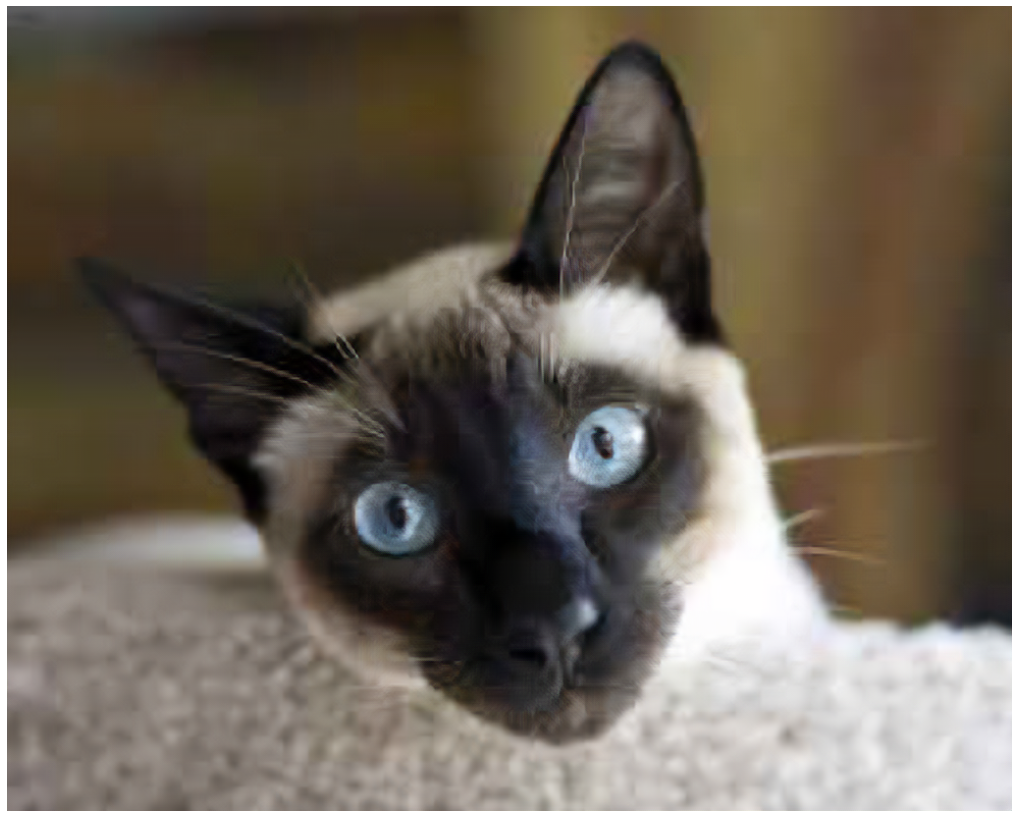

In [ ]:
Image(img_hr).show(figsize=(18,15))

In [ ]:
learn.export('/content/export.pkl')

In [ ]:
path = Path()

In [ ]:
path.ls()

[PosixPath('.config'), PosixPath('export.pkl'), PosixPath('sample_data')]

In [ ]:
learn_inf = load_learner('/content/')

In [ ]:
p, img_hr, b = learn_inf.predict(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


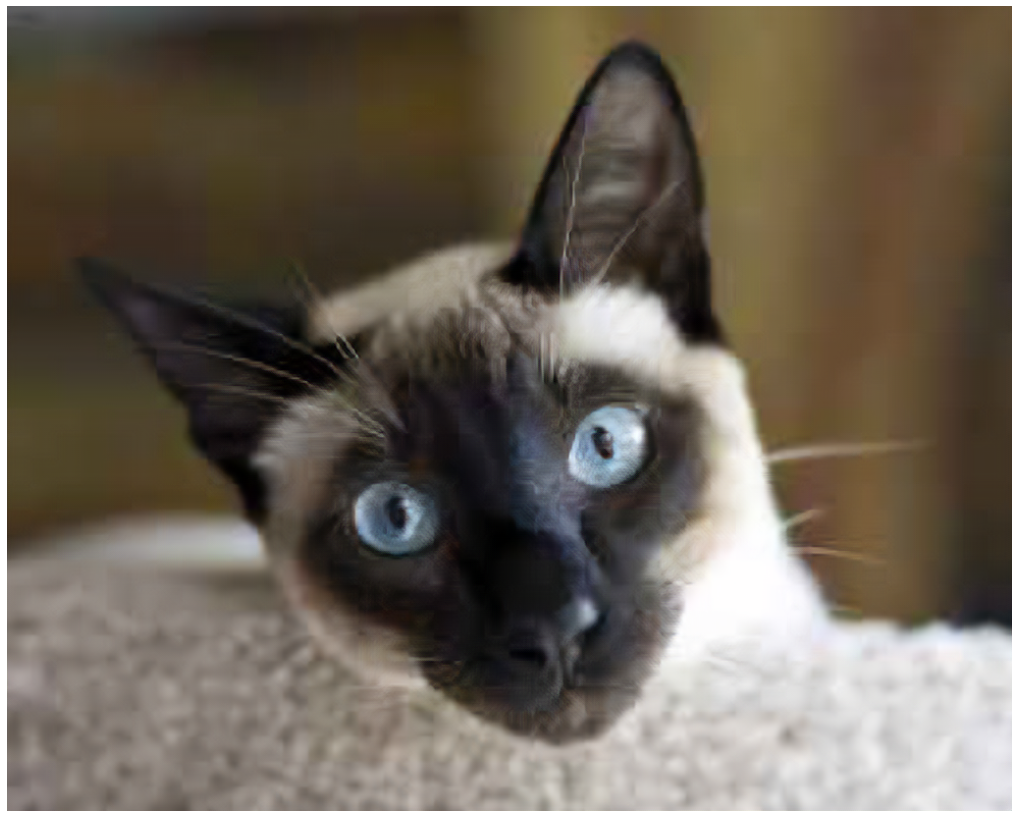

In [ ]:
Image(img_hr).show(figsize=(18,15))